# LAB 2.2

In [52]:
from abc import ABC, abstractmethod
from collections.abc import Sequence
from collections import Counter
from collections.abc import Sequence
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import heapq

class BaseEncoder(ABC):
    @abstractmethod
    def encode(self, stream):
        pass


class BaseDecoder(ABC):
    @abstractmethod
    def decode(self, stream):
        pass


class BaseCompressor(ABC):
    @property
    @abstractmethod
    def data(self):
        pass

    @data.setter
    @abstractmethod
    def data(self, data):
        pass


## Huffman algorithm

In [53]:
import heapq
from collections import Counter
from typing import Dict, List, Tuple


class HuffmanNode:
    def init(self, freq: int, char: str = None) -> None:
        self.freq = freq
        self.char = char
        self.left = None
        self.right = None

    def lt(self, other: "HuffmanNode") -> bool:
        return self.freq < other.freq


class HuffmanTree:
    def init(self, text: str) -> None:
        self.text = text
        self.tree = None

    def build_tree(self) -> None:
        char_freq = Counter(self.text)
        nodes = [HuffmanNode(freq=freq, char=char) for char, freq in char_freq.items()]
        heapq.heapify(nodes)

        while len(nodes) > 1:
            node_left = heapq.heappop(nodes)
            node_right = heapq.heappop(nodes)

            parent = HuffmanNode(freq=node_left.freq + node_right.freq)
            parent.left = node_left
            parent.right = node_right

            heapq.heappush(nodes, parent)

        self.tree = nodes[0]

    def get_codes(self) -> Dict[str, str]:
        codes = {}

        def traverse(node: HuffmanNode, code: str) -> None:
            if node.char:
                codes[node.char] = code
            else:
                traverse(node.left, code + "0")
                traverse(node.right, code + "1")

        traverse(self.tree, "")
        return codes


class HuffmanEncoder:
    def init(self, text: str) -> None:
        self.text = text
        self.tree = HuffmanTree(text)
        self.tree.build_tree()
        self.codes = self.tree.get_codes()

    def encode(self) -> Tuple[str, Dict[str, str]]:
        encoded = ""
        for char in self.text:
            encoded += self.codes[char]
        return encoded, self.codes


class HuffmanDecoder:
    def init(self, encoded: str, codes: Dict[str, str]) -> None:
        self.encoded = encoded
        self.codes = codes
        self.reverse_codes = {v: k for k, v in codes.items()}

    def decode(self) -> str:
        decoded = ""
        i = 0
        while i < len(self.encoded):
            j = i + 1
            while self.encoded[i:j] not in self.reverse_codes:
                j += 1
            decoded += self.reverse_codes[self.encoded[i:j]]
            i = j
        return decoded


class HuffmanCompressor:
    def compress(self, text: str) -> Tuple[str, Dict[str, str]]:
        encoder = HuffmanEncoder(text)
        encoded_text, codes = encoder.encode()
        return encoded_text, codes


The HuffmanNode class represents a node in the Huffman tree, with its frequency and character. The HuffmanTree class builds the Huffman tree from the input text, and the get_codes method returns a dictionary of the Huffman codes for each character in the text.The HuffmanEncoder class uses the Huffman tree and codes to encode the input text, returning the encoded text and the codes used for encoding. The HuffmanDecoder class uses the encoded text and codes to decode the text back to its original form.The HuffmanCompressor class uses the HuffmanEncoder and HuffmanDecoder classes to compress.

## LZW

In [54]:
class LZWEncoder(BaseEncoder):
    
    def __init__(self, _dict: dict = {chr(k): k for k in range(256)}):
        self._dict = _dict
        self._num = len(_dict)

    def encode(self, data, elem = '', encoded_data = []):
        for char in data:
            new_code = elem + char
            if new_code in self._dict:
                elem = new_code
            else:
                encoded_data.append(self._dict[elem])
                self._dict[new_code] = self._num
                self._num += 1
                elem = char

        if elem:
            encoded_data.append(self._dict[elem])

        return encoded_data


class LZWDecoder(BaseDecoder):
   
    def __init__(self, _dict = {key: chr(key) for key in range(256)}):
        self._dict = _dict
        self._num = len(_dict)


    def decode(self, data, elem = '', decoded_data = []):
        for code in data:
            if code in self._dict:
                entry = self._dict[code]
                decoded_data.append(entry)
                if elem:
                    self._dict[self._num] = elem + entry[0]
                    self._num += 1
                elem = entry
            else:
                entry = elem + elem[0]
                decoded_data.append(entry)
                self._dict[self._num] = entry
                self._num += 1
                elem = entry[-1]

        return ''.join(decoded_data)


class LZWCompressor(BaseCompressor):
    def __init__(self):
        self._encoder = LZWEncoder()
        self._decoder = LZWDecoder()
        self._data = []

    @property
    def data(self):
        
        return self._decoder.decode(self._data)

    @data.setter
    def data(self, data):
        
        self._data = self._encoder.encode(data = data)



The LZWEncoder class compresses data by first initializing a dictionary with 256 ASCII characters, and then adds substrings of the input text to the dictionary as they are encountered. The dictionary entries are assigned numerical codes that are output in the compressed data. The LZWDecoder class reads these codes and uses them to rebuild the original text by maintaining a dictionary of the same entries as the encoder. The LZWCompressor class serves as a wrapper for the encoder and decoder, with the data property handling the conversion between compressed and decompressed data.

## LZ77

In [55]:
class LZ77:
    def __init__(self, window_size):
        self.window_size = window_size
        self.window = ''

    def encode(self, input_string):
        encoded_string = []
        while len(input_string) > 0:
            match = ''
            match_distance = 0
            match_length = 0
            for i in range(len(self.window)):
                j = 0
                while j<len(input_string) and i+j<len(self.window) and input_string[j]==self.window[i+j]:
                    j += 1
                if j > match_length:
                    match_length = j
                    match_distance = len(self.window) - i
                    if j < len(input_string):
                        match = input_string[0:j+1]
                    else:
                        match = input_string
            if match_length > 0:
                encoded_string.append((match_distance, match_length, match[-1]))
                input_string = input_string[match_length+1:]
                self.window += match
            else:
                encoded_string.append((0, 0, input_string[0]))
                input_string = input_string[1:]
                self.window += encoded_string[-1][-1]
            if len(self.window) > self.window_size:
                self.window = self.window[1:]
        with open('encoded_message.txt','w',encoding = 'UTF-8') as file:
            for i in encoded_string:
                file.write(f'{i}\n')
        return encoded_string

    def decode(self, encoded_string):
        input_string = ''
        for triplet in encoded_string:
            distance, length, char = triplet
            if length == 0:
                input_string += char
            else:
                start_index = len(input_string) - distance
                for i in range(length):
                    input_string += input_string[start_index + i]
                input_string += char
        with open ('new.txt','w',encoding = 'UTF-8') as file:
            file.write(input_string)
        return input_string[:-1]

The LZ77 class has an init() method that initializes the window size and an empty window. The encode() method takes an input string. The method identifies repeated patterns of data within a sliding window and outputs a tuple containing the match distance, match length, and the next character in the input string. These tuples are stored in a list, which is written to a file named "encoded_message.txt". The decode() method takes an encoded string, which was previously generated by the encode() method, and decompresses it using the LZ77 algorithm. The decoded string is written to a file named "new.txt".

## Analys of time complexity

There is graffic of time versus number of symbols

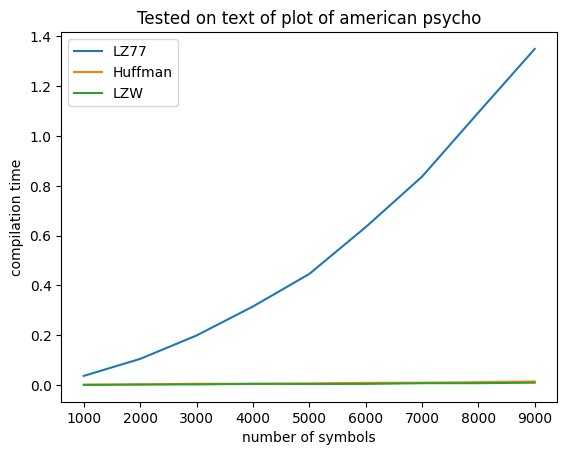

In [63]:
import matplotlib.pyplot as plt

x1 = [1000,2000,3000,4000,5000,6000,7000,8000,9000]
y1 = [0.037358999252319336,0.10547685623168945,0.19942688941955566,0.31567811965942383,0.4463529586791992,0.6340920925140381,0.8367531299591064,1.0941853523254395,1.3494298458099365]
x2 = x1
y2 = [0.0020194053649902344, 0.0021882057189941406, 0.005766630172729492, 0.005022764205932617, 0.006987094879150391, 0.009321928024291992, 0.009912967681884766, 0.012022972106933594, 0.014944076538085938]
x3 = x1
y3 = [0.0009968280792236328, 0.0029964447021484375, 0.0030202865600585938, 0.005542755126953125, 0.0049555301666259766, 0.005071878433227539, 0.007895708084106445, 0.007979631423950195, 0.010004043579101562]
plt.plot(x1,y1,label = 'LZ77')
plt.plot(x2, y2,label = 'Huffman')
plt.plot(x3,y3,label = 'LZW')
plt.plot()
plt.xlabel('number of symbols')
plt.ylabel('compilation time')
plt.title('Tested on text of plot of "American psycho"')
plt.legend()
plt.show()

## Graffic of compression versus number of symbols

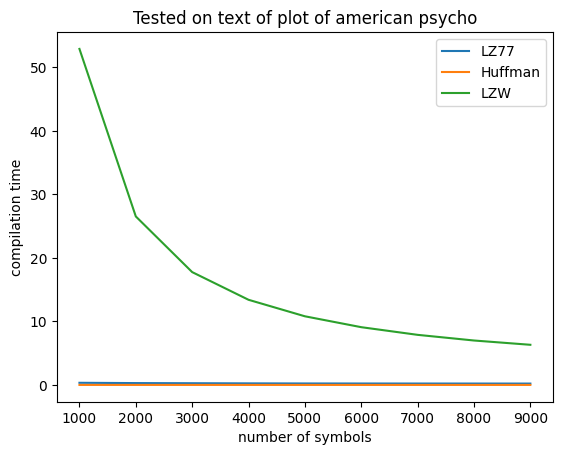

In [64]:
import matplotlib.pyplot as plt

x1 = [1000,2000,3000,4000,5000,6000,7000,8000,9000]
y1 = [0.34,0.294,0.2713333333333333,0.24925,0.2338,0.22816666666666666,0.22357142857142856,0.221,0.21722222222222223]
x2 = x1
y2 = [0.005, 0.005, 0.005, 0.00475, 0.0048, 0.004833333333333334, 0.004857142857142857, 0.00475, 0.0047777777777777775]
x3 = x1
y3 = [52.92, 26.538, 17.772, 13.41175, 10.8132, 9.097666666666667, 7.890571428571429, 6.99975, 6.324333333333334]
plt.plot(x1,y1,label = 'LZ77')
plt.plot(x2, y2,label = 'Huffman')
plt.plot(x3,y3,label = 'LZW')
plt.plot()
plt.xlabel('number of symbols')
plt.ylabel('coef of compression')
plt.title('Tested on text of plot of "American psycho"')
plt.legend()
plt.show()

# Summary

LZ77: The algorithm works well for textual data consisting of many repeated consequences. And bad for random data, after which it can lead not only to inefficient compression, but also to increased data sizes.

LZW: This algoritm is a relatively simple and efficient way to compress text data, with good compression rates for many types of data.However, it may not perform as well on non-text data or on data with low redundancy.

Huffman: This code provides a basic implementation of Huffman coding for data compression. However, it has some limitations, such as not being able to handle Unicode.